---
#MySQL資料分析，side project ：

#你是A公司的新進SQL數據分析師，請你從各個角度分析A公司1996～1998年的各種業務數據，從中來評估A公司的
#【員工能力評估、員工銷售績效分析】、
#【客群分析（國家、購買力、活躍客戶）】、
#【熱門銷售產品分析、受喜愛產品分析】、
#【逐年逐月業績分析】
#最後請寫份摘要報告。請多用定量描述的方式，來證明你分析觀點的可靠性、準確性與權威性，以建立個人數據分析的品牌與形象。

---
#2.需要安裝新的資料庫：company2 企業內部業務資料庫，請自行下載安裝到workbench到你的local資料庫
https://acupun.site/lecture/sql/example/sql/company2-edit01.zip

安裝時，下面的選項不用修改，直接OK安裝

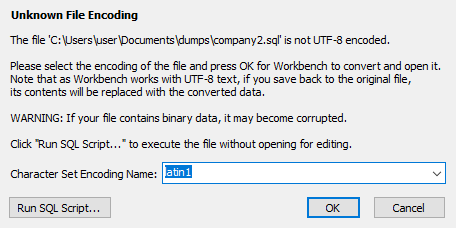


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**


---
#安裝MySQL的python的驅動程式碼

In [ ]:
!pip install pymysql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00


---
#連線第1個資料庫：company2企業內部業務資料庫

#會員user1
密碼：123@Ntut

資料庫：company2

Azure主機：ccw-mysql.mysql.database.azure.com

In [ ]:
#連線Azure mysql資料庫指令
import pymysql
conn = pymysql.connect(
      host="ccw-mysql.mysql.database.azure.com",
      user="user1",
      password="123@Ntut",
      database="company2")

---
# 1.找出未曾下單的客戶資料
#目的：找出本公司的待開發之潛在客戶

In [ ]:
import pandas as pd

sql = """
select customers.CustomerID, customers.CompanyName, customers.ContactName
from orders
right join customers
	on orders.CustomerID = customers.CustomerID
where orders.CustomerID is null;"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-3-284e3a9111e2>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,ContactName
0,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel
1,PARIS,Paris spcialits,Marie Bertrand
2,Val2,IT,Val2
3,VALON,IT,Valon Hoti


---
# 2.根據訂單數量為產品分類
若產品的訂單數量<10，則標示『銷量差』

若產品的訂單數量<=20 而且>=10，則標示『銷量普通』

若產品的訂單數量>20，則標示『銷量好』
#目的：將本公司產品，進行分類【銷量差，銷量普通，銷量好】

In [ ]:
sql = """
select  products.ProductID, products.ProductName,
		case
			 when count(*) < 10 then '銷量差'
             when count(*) >= 10 and count(*) < 20 then '銷量普通'
             else '銷量好'
        end as 銷售產品等級
from products
left join `order details`
	on products.ProductID = `order details`.ProductID
group by products.ProductID, products.ProductName;"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-4-20efbcbf449a>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,銷售產品等級
0,17,Alice Mutton,銷量好
1,3,Aniseed Syrup,銷量普通
2,40,Boston Crab Meat,銷量好
3,60,Camembert Pierrot,銷量好
4,18,Carnarvon Tigers,銷量好
...,...,...,...
72,7,Uncle Bob's Organic Dried Pears,銷量好
73,50,Valkoinen suklaa,銷量普通
74,63,Vegie-spread,銷量普通
75,64,Wimmers gute Semmelkndel,銷量好


---
# 3.根據銷售金額，對員工進行排名
#目的：找出表現好的員工並予以嘉獎，也找出表現差的員工，先輔導，再不行則辭退
不需要考慮【Order Details】裡面的Discount

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
sql = """
select e.EmployeeID, e.FirstName, e.LastName,
		rank() over(order by sum(od.UnitPrice * od.Quantity) desc) 銷售排名
from orders o
join employees e
	on o.EmployeeID = e.EmployeeID
join  `order details` od
on o.OrderID = od.OrderID
group by e.EmployeeID; # , FirstName, LastName; # 後面可寫可不寫
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-6-f3f177443f08>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,EmployeeID,FirstName,LastName,銷售排名
0,4,Margaret,Peacock,1
1,3,Janet,Leverling,2
2,1,Nancy,Davolio,3
3,2,Andrew,Fuller,4
4,7,Robert,King,5
5,8,Laura,Callahan,6
6,9,Anne,Dodsworth,7
7,6,Michael,Suyama,8
8,5,Steven,Buchanan,9


---
# 4.根據國家來統計客戶數量
#目的：評估本公司海外客戶，哪些國家是主要客群

In [ ]:
sql = """
select Country,
	count(*) as 客戶數量
from customers
group by Country;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-7-a6ce04832654>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,Country,客戶數量
0,Germany,11
1,Mexico,5
2,UK,7
3,Sweden,2
4,France,11
5,Spain,5
6,Canada,3
7,Argentina,3
8,Switzerland,2
9,Brazil,9


---
# 5.找出至少下過5個訂單的客戶

#目的：找出本公司的活躍客戶，不斷重複下單

In [ ]:
sql = """
select c.CustomerID, c.CompanyName,
		count(*) as 下單次數
from orders o
join customers c
on	o.CustomerID = c.CustomerID
group by o.CustomerID
having 下單次數 >= 5;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-8-9115f3760330>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,下單次數
0,ALFKI,Alfreds Futterkiste,6
1,ANTON,Antonio Moreno Taquera,7
2,AROUT,Around the Horn,13
3,BSBEV,B's Beverages,10
4,BERGS,Berglunds snabbkp,18
...,...,...,...
68,WARTH,Wartian Herkku,15
69,WELLI,Wellington Importadora,9
70,WHITC,White Clover Markets,14
71,WILMK,Wilman Kala,7


---
#6.計算每個產品類別銷售額，佔總銷售額的百分比
#目的：分析本公司各類產品，哪些是佔營收大宗的主要銷售大類？
不需要考慮【Order Details】裡面的Discount

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
sql = """
select CategoryName,
	(sum(o.UnitPrice * o.Quantity) / (select sum(UnitPrice * Quantity)
									 from `order details`) * 100) 佔比
from `order details` o
join products p
	on o.ProductID = p.ProductID
join categories c
	on p.CategoryID = c.CategoryID
group by CategoryName;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-9-06e8aee58c81>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,佔比
0,Beverages,21.154353
1,Condiments,8.394110
2,Confections,13.075269
3,Dairy Products,18.555791
4,Grains/Cereals,7.436684
5,Meat/Poultry,13.155722
6,Produce,7.772006
7,Seafood,10.456066


---
# 7.製作不同員工，在不同國家的訂單數量分析表
#目的：評估不同員工，對不同國家的銷售能力

In [ ]:
sql = """
select FirstName, LastName, c.Country,
	count(c.Country) as 訂單數量
from orders o
join employees e
	on o.EmployeeID = e.EmployeeID
join customers c
	on o.CustomerID = c.CustomerID
group by FirstName, LastName, c.Country;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-5-933b849430b5>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,FirstName,LastName,Country,訂單數量
0,Nancy,Davolio,Austria,5
1,Nancy,Davolio,Finland,2
2,Nancy,Davolio,Italy,5
3,Nancy,Davolio,Germany,19
4,Nancy,Davolio,Brazil,11
...,...,...,...,...
162,Anne,Dodsworth,Venezuela,1
163,Anne,Dodsworth,Finland,1
164,Anne,Dodsworth,Argentina,2
165,Anne,Dodsworth,Portugal,1


---
# 8.找出所有訂單中最昂貴單價的前5個產品
#目的：評估本公司有被下訂的產品，哪些的CP值高（單價高，又有人買）

In [ ]:
sql = """
SELECT p.ProductID, p.ProductName, p.UnitPrice as 最昂貴價格
FROM `order details` od
join products p
	on od.ProductID = p.ProductID
group by p.ProductID
order by p.UnitPrice desc
limit 5;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-7-f66bf04f979c>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,最昂貴價格
0,38,Cte de Blaye,263.50
1,29,Thringer Rostbratwurst,123.79
2,9,Mishi Kobe Niku,97.00
3,20,Sir Rodney's Marmalade,81.00
4,18,Carnarvon Tigers,62.50


---
# 9.找出所有訂單中還未發貨的訂單資料

In [ ]:
sql = """
select OrderID, CustomerID, OrderDate, ShippedDate
from orders
where ShippedDate is null;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-6-3d9d9b934833>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,OrderID,CustomerID,OrderDate,ShippedDate
0,11008,ERNSH,1998-04-08,None
1,11019,RANCH,1998-04-13,None
2,11039,LINOD,1998-04-21,None
3,11040,GREAL,1998-04-22,None
4,11045,BOTTM,1998-04-23,None
5,11051,LAMAI,1998-04-27,None
6,11054,CACTU,1998-04-28,None
7,11058,BLAUS,1998-04-29,None
8,11059,RICAR,1998-04-29,None
9,11061,GREAL,1998-04-30,None


---
# 10.顯示每個客戶的平均訂單金額，請依照平均訂單金額排序
#目的：評估每個客戶的購買能力，從此來評估哪些客戶是有購買力的大客戶（富豪）

不需要考慮【Order Details】裡面的Discount


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
sql = """
select c.CustomerID, c.CompanyName,
	avg(od.UnitPrice * od.Quantity) 平均訂單金額
from orders o
join customers c
	on o.CustomerID = c.CustomerID
join `order details` od
	on o.OrderID = od.OrderID
group by c.CustomerID
order by 平均訂單金額 desc;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-7-da2eaf1d3572>:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,平均訂單金額
0,QUICK,QUICK-Stop,1366.085930
1,SIMOB,Simons bistro,1209.230000
2,PICCO,Piccolo und mehr,1141.736957
3,ERNSH,Ernst Handel,1110.163529
4,HANAR,Hanari Carnes,1065.660938
...,...,...,...
84,NORTS,North/South,108.166667
85,ROMEY,Romero y tomillo,104.806429
86,GALED,Galera del gastrnomo,104.587500
87,LAUGB,Laughing Bacchus Wine Cellars,65.312500


---
# 11.統計每個類別下的產品數量。

In [ ]:
sql = """
select CategoryName, count(c.CategoryID) as 產品數量
from products p
join categories c
	on p.CategoryID = c.CategoryID
group by c.CategoryID;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-8-6e7d4dc63f3a>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,產品數量
0,Beverages,12
1,Condiments,12
2,Confections,13
3,Dairy Products,10
4,Grains/Cereals,7
5,Meat/Poultry,6
6,Produce,5
7,Seafood,12


---
# 12.找出銷售總額低於平均水準的員工
#找出需要再教育訓練，需要再加強行銷能力的員工
不需要考慮【Order Details】裡面的Discount

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**


In [ ]:
sql = """
select e.EmployeeID, FirstName, LastName,
	sum(od.UnitPrice * od.Quantity) 銷售總額
from orders o
join employees e
	on o.EmployeeID = e.EmployeeID
join `order details` od
	on o.OrderID = od.OrderID
group by e.EmployeeID
having sum(od.UnitPrice * od.Quantity) < (select sum(UnitPrice * Quantity) /
										 (select count(*)
                                          from employees)
                                          from `order details`);
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-9-a1f1cdfa49da>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,EmployeeID,FirstName,LastName,銷售總額
0,5,Steven,Buchanan,75567.75
1,6,Michael,Suyama,78198.10
2,7,Robert,King,141295.99
3,8,Laura,Callahan,133301.03
4,9,Anne,Dodsworth,82964.00


In [ ]:
sql = """
select e.EmployeeID, e.FirstName, e.LastName,
	sum(od.UnitPrice * od.Quantity) as 銷售總額
from orders o
join employees e
	on o.EmployeeID = e.EmployeeID
join `order details` od
	on o.OrderID = od.OrderID
group by e.EmployeeID, e.FirstName, e.LastName
having 銷售總額 < (select avg(TotalSales)
				   from
						 (select sum(od.UnitPrice * od.Quantity) as TotalSales
						  from employees e
						  join orders o
							on e.EmployeeID = o.EmployeeID
						  join `order details` od
						    on o.OrderID = od.OrderID
						  group by e.EmployeeID) as t1);
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-10-5be9472fe25a>:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,EmployeeID,FirstName,LastName,銷售總額
0,5,Steven,Buchanan,75567.75
1,6,Michael,Suyama,78198.10
2,7,Robert,King,141295.99
3,8,Laura,Callahan,133301.03
4,9,Anne,Dodsworth,82964.00


---
# 13.顯示所有訂單的總銷售額
不需要考慮【Order Details】裡面的Discount


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
sql = """
select sum(UnitPrice * Quantity) as 銷售總額
from `order details`;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-4-24663e484ff9>:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,銷售總額
0,1354458.59


---
# 14.列出至少有5個不同客戶下訂單的產品
#目的：查詢本公司收客戶歡迎的產品：只要被5個以上客戶下訂，就表示該產品受歡迎


#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
sql = """
select p.ProductID, p.ProductName, count(distinct CustomerID) as 客戶下單數
from `order details` od
join products p
	on od.ProductID = p.ProductID
join orders o
	on o.OrderID = od.OrderID
group by p.ProductID, p.ProductName
having 客戶下單數 >= 5;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-4-0be5996ee4a9>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,客戶下單數
0,1,Chai,31
1,2,Chang,28
2,3,Aniseed Syrup,10
3,4,Chef Anton's Cajun Seasoning,17
4,5,Chef Anton's Gumbo Mix,9
...,...,...,...
72,73,Rd Kaviar,11
73,74,Longlife Tofu,11
74,75,Rhnbru Klosterbier,33
75,76,Lakkalikri,33


---
# 15.找出至少向本公司購買過3種不同產品的客戶資料
#目的：找出本公司的活躍客戶，或喜歡本公司產品的客戶（購買多種產品）

#**注意：訂單明細【Order Details】，要寫成：’Order Details'，要前後加上反引號**

In [ ]:
sql = """
select c.CustomerID, c.CompanyName, count(distinct od.ProductID) as 購買不同產品數量
from orders o
join customers c
	on o.CustomerID = c.CustomerID
join `order details` od
	on o.OrderID = od.OrderID
group by c.CustomerID, c.CompanyName
having 購買不同產品數量 >= 3;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-5-f6b07c0f4d89>:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName,購買不同產品數量
0,ALFKI,Alfreds Futterkiste,11
1,ANATR,Ana Trujillo Emparedados y helados,10
2,ANTON,Antonio Moreno Taquera,15
3,AROUT,Around the Horn,24
4,BERGS,Berglunds snabbkp,37
...,...,...,...
82,WARTH,Wartian Herkku,28
83,WELLI,Wellington Importadora,16
84,WHITC,White Clover Markets,32
85,WILMK,Wilman Kala,17


---
# 16.統計每年，每個月的訂單數量
#目的：可以看出逐年逐月的銷售趨勢

In [ ]:
sql = """
select year(OrderDate) as 年,
       month(OrderDate) as 月, # date_format(OrderDate, '%m')會有0
       count(*) as 訂單總量
from orders
group by 年, 月;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-6-40e4d0b1602f>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,年,月,訂單總量
0,1996,7,22
1,1996,8,25
2,1996,9,23
3,1996,10,26
4,1996,11,25
5,1996,12,31
6,1997,1,33
7,1997,2,29
8,1997,3,30
9,1997,4,31


---
# 17.供應商的產品銷售分析:
#分析每個供應商的產品總銷售額和總銷售量，

#並按銷售額排序展示供應商

In [ ]:
import pandas as pd
sql = """
select s.SupplierID, s.CompanyName,
	sum(od.Quantity) as 總銷售數量,
    sum(od.UnitPrice * od.Quantity) as 總銷售額
from suppliers s
join products p
	on s.SupplierID = p.SupplierID
join `order details` od
	on p.ProductID = od.ProductID
group by s.SupplierID, s.CompanyName
order by 總銷售額 desc;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-5-9129d8d1c682>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,SupplierID,CompanyName,總銷售數量,總銷售額
0,18,Aux joyeux ecclsiastiques,1416.0,163135.00
1,12,Plutzer Lebensmittelgromrkte AG,4072.0,155946.55
2,28,Gai pturage,3073.0,126582.00
3,7,"Pavlova, Ltd.",3937.0,115386.05
4,24,"G'day, Mate",2108.0,69636.60
5,29,Forts d'rables,1686.0,66266.70
6,26,Pasta Buttini s.r.l.,1697.0,52929.00
7,14,Formaggi Fortini s.r.l.,2500.0,51082.50
8,8,"Specialty Biscuits, Ltd.",2851.0,48793.80
9,15,Norske Meierier,2526.0,46897.20


---
# 18.【產品類別categories】的銷售季節性分析
#探討不同產品類別在不同季節的銷售表現
#補充指令：
取出年：year(now())

取出月：month(now())

**取出季節：quarter(now())**

In [ ]:
sql = """
select c.CategoryName, year(o.OrderDate) as 年, quarter(o.OrderDate) as 季,
	sum(od.Quantity) as 總銷售量, sum(od.Quantity * od.UnitPrice) as 總銷售額
from orders o
join `order details` od
	on o.OrderID = od.OrderID
join products p
	on od.ProductID = p.ProductID
join categories c
	on p.CategoryID = c.CategoryID
group by c.CategoryName, year(o.OrderDate), quarter(o.OrderDate);
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-6-4c21c876f72a>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CategoryName,年,季,總銷售量,總銷售額
0,Beverages,1996,3,904.0,13606.00
1,Beverages,1996,4,938.0,40273.20
2,Beverages,1997,1,1021.0,38342.00
3,Beverages,1997,2,903.0,26633.50
4,Beverages,1997,3,835.0,20696.25
...,...,...,...,...,...
59,Seafood,1997,2,786.0,14366.70
60,Seafood,1997,3,1298.0,26938.83
61,Seafood,1997,4,1119.0,22077.92
62,Seafood,1998,1,1968.0,37138.38


---
# 19.找出新產品的潛在客戶
#本公司最近推出了一個新的產品：Tofu
#請找出尚未購買此類產品的客戶。


In [ ]:
sql = """
select c.CustomerID, c.CompanyName
from
	(select c.CustomerID, c.CompanyName
	from orders o
	join `order details` od
		on o.OrderID = od.OrderID
	right join customers c
		on o.CustomerID = c.CustomerID
	where od.ProductID = 14
	group by c.CustomerID, c.CompanyName) as t1
right join customers c
	on t1.CustomerID = c.CustomerID
where t1.CustomerID is null;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-7-b44718ebe0c5>:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName
0,ALFKI,Alfreds Futterkiste
1,ANTON,Antonio Moreno Taquera
2,AROUT,Around the Horn
3,BSBEV,B's Beverages
4,BLAUS,Blauer See Delikatessen
...,...,...
70,VINET,Vins et alcools Chevalier
71,WELLI,Wellington Importadora
72,WHITC,White Clover Markets
73,WILMK,Wilman Kala


---
# 20.計算每種運輸方式（ShipVia）的使用頻率：
#根據Orders表中的運輸方式，計算每種方式的使用次數，
#並計算其佔總運輸次數的百分比。
#ShipVia = 運送途徑
陸運：

海運：

空運：

快遞服務：例如快遞公司：UPS、FedEx等。

In [ ]:
sql = """
select ShipVia, count(*) as 使用次數,
	(count(*) / (select count(ShipVia)
				 from orders) * 100) as 使用頻率
from orders
group by ShipVia;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-8-231150d0433e>:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ShipVia,使用次數,使用頻率
0,1,249,30.0000
1,2,326,39.2771
2,3,255,30.7229


---
# 21.分群兩個維度【年，季】的銷售分析，並用Tableau視覺化呈現：
#每季度的銷售分析：計算每季度的總銷售額，分析銷售的趨勢
#將交叉分析表的數據下載後（檔名不要用中文，不要有空格或特殊符號），傳給Tableau，畫出圖表，後將圖表網址貼在以下的【程式碼儲存格】裡面

#補充指令：
取出年：year(now())

取出月：month(now())

**取出季節：quarter(now())**

In [ ]:
sql = """
select year(o.OrderDate) as 年, quarter(o.OrderDate) as 季,
	sum(od.Quantity * od.UnitPrice) 總銷售額
from orders o
join `order details` od
	on o.OrderID = od.OrderID
group by year(o.OrderDate), quarter(o.OrderDate);
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-9-b0011bd77f04>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,年,季,總銷售額
0,1996,3,84437.50
1,1996,4,141861.00
2,1997,1,147879.90
3,1997,2,151611.09
4,1997,3,165179.64
5,1997,4,193718.12
6,1998,1,315242.12
7,1998,2,154529.22


In [ ]:
'''
Tableau圖表的網址，貼在這裡：
https://public.tableau.com/app/profile/.46152877/viz/110AB0028/110AB0028#1

'''

'\nTableau圖表的網址，貼在這裡：\nhttps://public.tableau.com/app/profile/.46152877/viz/110AB0028/110AB0028#1\n\n'

---
#22.產品銷售排名與庫存狀態(UnitsInStock)：
#對產品按銷售總量進行排名，並顯示其庫存狀態。

In [ ]:
sql = """
select p.ProductID, p.ProductName,
	sum(od.Quantity) as 銷售總量, p.UnitsInStock as 目前庫存
from products p
join `order details` od
	on p.ProductID = od.ProductID
group by p.ProductID
order by 銷售總量 desc;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-10-4f1032eb35d1>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,ProductID,ProductName,銷售總量,目前庫存
0,60,Camembert Pierrot,1577.0,19
1,59,Raclette Courdavault,1496.0,79
2,31,Gorgonzola Telino,1397.0,0
3,56,Gnocchi di nonna Alice,1263.0,21
4,16,Pavlova,1158.0,29
...,...,...,...,...
72,67,Laughing Lumberjack Lager,184.0,52
73,48,Chocolade,138.0,15
74,37,Gravad lax,125.0,11
75,15,Genen Shouyu,122.0,39


---
#23.客戶忠誠度分析：
#找出至少重複下單15次的客戶，


In [ ]:
sql = """
select c.CustomerID, c.CompanyName
from orders o
join customers c
	on o.CustomerID = c.CustomerID
group by c.CustomerID, c.CompanyName
having count(*) >= 15;
"""
df = pd.read_sql_query(sql, conn)
df

<ipython-input-11-709cb6610556>:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


,CustomerID,CompanyName
0,BERGS,Berglunds snabbkp
1,BONAP,Bon app'
2,ERNSH,Ernst Handel
3,FOLKO,Folk och f HB
4,FRANK,Frankenversand
5,HILAA,HILARION-Abastos
6,HUNGO,Hungry Owl All-Night Grocers
7,LEHMS,Lehmanns Marktstand
8,QUICK,QUICK-Stop
9,RATTC,Rattlesnake Canyon Grocery


---
#24.請在company2資料庫裡面，執行以下幾個DML/DDL指令
#(1).新增資料表【departments】
#欄位：empID，dept_name，dept_title，Seniority
解釋：empID員工編號，

dept_name部門名稱，

dept_title職場稱謂，

Seniority工作年資(年)

#員工編號要設定主索引鍵，也要設定自動編號

#(2).新增2筆記錄

#(3).修改empID=1的員工，設定他的dept_name為生產處，dept_titel為工程師，年資為5

#(4).刪除資料表【departments】

請把上述四項的DML/DDL指令，全部寫在以下的【程式碼儲存格】裡面


In [ ]:
'''
上述四項的DML/DDL指令，貼在這裡：
create table departments(empID int primary key auto_increment,
						 dept_name varchar(20),
                         dept_title varchar(20),
                         Seniority int);

select *
from departments;

insert into departments(dept_name, dept_title, Seniority)
				 values('資財', '資安師', 6);

insert into departments(dept_name, dept_title, Seniority)
				 values('經管', '設計師', 8);

update departments
set dept_name = '生產處', dept_title = '工程師', Seniority = 5
where empID = 1;

drop table departments;

'''

---
# 100.關閉連線

In [ ]:
#關閉連線
#conn.close()